**Cada experimento realizado debe estar acompañado de una explicación o interpretación de lo observado.**

**1**. Vectorizar documentos. Tomar 5 documentos al azar y medir similaridad con el resto de los documentos.
Estudiar los 5 documentos más similares de cada uno analizar si tiene sentido
la similaridad según el contenido del texto y la etiqueta de clasificación.

**2**. Construir un modelo de clasificación por prototipos (tipo zero-shot). Clasificar los documentos de un conjunto de test comparando cada uno con todos los de entrenamiento y asignar la clase al label del documento del conjunto de entrenamiento con mayor similaridad.

**3**. Entrenar modelos de clasificación Naïve Bayes para maximizar el desempeño de clasificación
(f1-score macro) en el conjunto de datos de test. Considerar cambiar parámteros
de instanciación del vectorizador y los modelos y probar modelos de Naïve Bayes Multinomial
y ComplementNB.

**NO cambiar el hiperparámetro ngram_range de los vectorizadores**.

**4**. Transponer la matriz documento-término. De esa manera se obtiene una matriz
término-documento que puede ser interpretada como una colección de vectorización de palabras.
Estudiar ahora similaridad entre palabras tomando 5 palabras y estudiando sus 5 más similares.

**Elegir las palabras MANUALMENTE para evitar la aparición de términos poco interpretables**.


# Instalamos las librerias y demas dependencias

In [15]:
%pip install numpy scikit-learn

In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import f1_score
# 20newsgroups por ser un dataset clásico de NLP ya viene incluido y formateado
# en sklearn
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import matplotlib.pyplot as plt

1. Vectorizar documentos. Tomar 5 documentos al azar y medir similaridad con el resto de los documentos. Estudiar los 5 documentos más similares de cada uno analizar si tiene sentido la similaridad según el contenido del texto y la etiqueta de clasificación.

In [17]:

# 1) Cargar datos
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test  = fetch_20newsgroups(subset='test',  remove=('headers', 'footers', 'quotes'))

X_train_text, y_train = newsgroups_train.data, newsgroups_train.target
X_test_text,  y_test  = newsgroups_test.data,  newsgroups_test.target
target_names = newsgroups_train.target_names


Analisamos la propocionalidad de las distintas clases

Frecuencias TRAIN:
                       clase  frecuencia  proporcion
0           rec.sport.hockey         600    0.053032
1     soc.religion.christian         599    0.052943
2            rec.motorcycles         598    0.052855
3         rec.sport.baseball         597    0.052766
4                  sci.crypt         595    0.052590
5                  rec.autos         594    0.052501
6                    sci.med         594    0.052501
7             comp.windows.x         593    0.052413
8                  sci.space         593    0.052413
9            sci.electronics         591    0.052236
10   comp.os.ms-windows.misc         591    0.052236
11  comp.sys.ibm.pc.hardware         590    0.052148
12              misc.forsale         585    0.051706
13             comp.graphics         584    0.051617
14     comp.sys.mac.hardware         578    0.051087
15     talk.politics.mideast         564    0.049850
16        talk.politics.guns         546    0.048259
17               alt.atheis

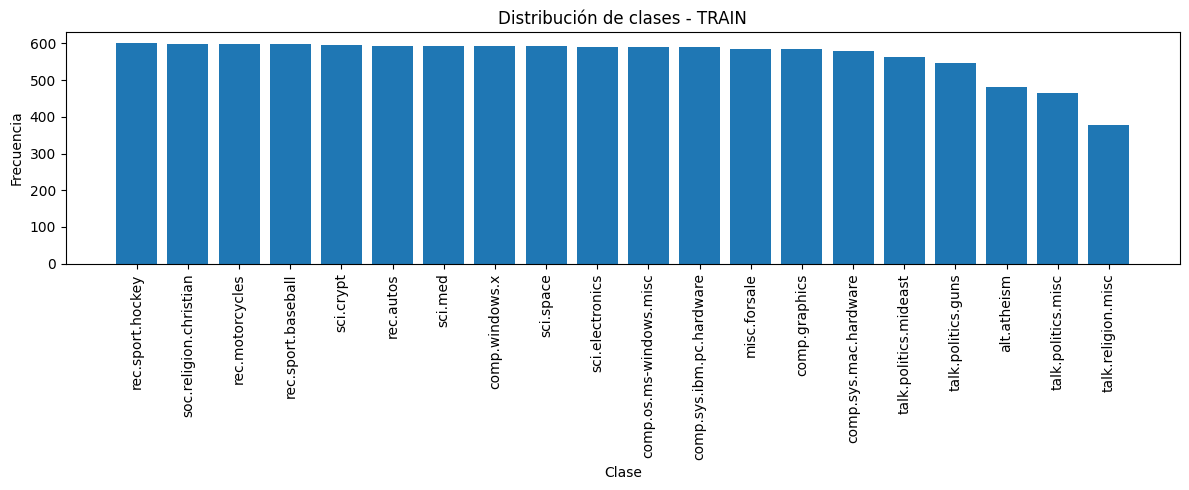

Imbalance ratio TRAIN (max/min): 1.59

Frecuencias TEST:
                       clase  frecuencia  proporcion
0           rec.sport.hockey         399    0.052974
1            rec.motorcycles         398    0.052841
2     soc.religion.christian         398    0.052841
3         rec.sport.baseball         397    0.052708
4                  sci.crypt         396    0.052576
5                  rec.autos         396    0.052576
6                    sci.med         396    0.052576
7             comp.windows.x         395    0.052443
8                  sci.space         394    0.052310
9    comp.os.ms-windows.misc         394    0.052310
10           sci.electronics         393    0.052177
11  comp.sys.ibm.pc.hardware         392    0.052045
12              misc.forsale         390    0.051779
13             comp.graphics         389    0.051646
14     comp.sys.mac.hardware         385    0.051115
15     talk.politics.mideast         376    0.049920
16        talk.politics.guns         364  

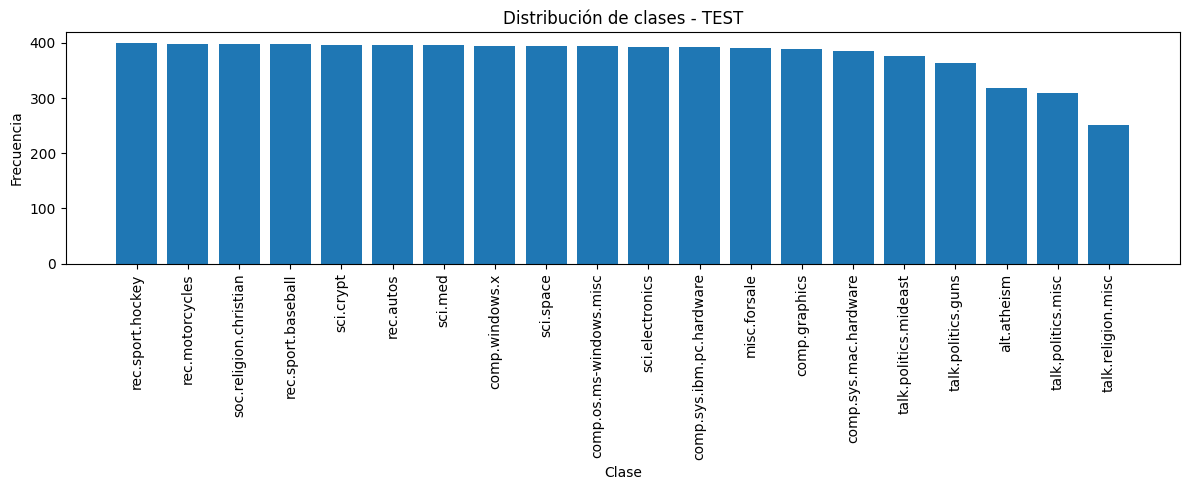

Imbalance ratio TEST (max/min): 1.59


In [18]:
# --- Función auxiliar: arma tabla de frecuencias ---
def class_freq_table(y, target_names, sort_desc=True):
    counts = np.bincount(y, minlength=len(target_names))
    df = pd.DataFrame({"clase": target_names, "frecuencia": counts})
    if sort_desc:
        df = df.sort_values("frecuencia", ascending=False).reset_index(drop=True)
    df["proporcion"] = df["frecuencia"] / df["frecuencia"].sum()
    return df

# --- 1) Tabla y gráfico para TRAIN ---
df_train = class_freq_table(y_train, target_names, sort_desc=True)
print("Frecuencias TRAIN:")
print(df_train)

plt.figure(figsize=(12, 5))
plt.bar(df_train["clase"], df_train["frecuencia"])
plt.title("Distribución de clases - TRAIN")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

imbalance_ratio_train = df_train["frecuencia"].max() / df_train["frecuencia"].min()
print(f"Imbalance ratio TRAIN (max/min): {imbalance_ratio_train:.2f}")

# --- 2) Tabla y gráfico para TEST (opcional) ---
df_test = class_freq_table(y_test, target_names, sort_desc=True)
print("\nFrecuencias TEST:")
print(df_test)

plt.figure(figsize=(12, 5))
plt.bar(df_test["clase"], df_test["frecuencia"])
plt.title("Distribución de clases - TEST")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

imbalance_ratio_test = df_test["frecuencia"].max() / df_test["frecuencia"].min()
print(f"Imbalance ratio TEST (max/min): {imbalance_ratio_test:.2f}")


In [19]:


# 2) Vectorizar (TF-IDF)
vect = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    max_df=0.8,
    min_df=2,
    sublinear_tf=True,
    norm='l2'
)
X_train = vect.fit_transform(X_train_text)
X_test  = vect.transform(X_test_text)

# 3) Elegir 5 documentos al azar del test (reproducible)
rng = np.random.default_rng(42)
idx_test_sample = rng.choice(X_test.shape[0], size=5, replace=False)

# 4) Para cada doc del sample, medir similitud con TODOS los de train (usando cosine_similarity)
for i, idx in enumerate(idx_test_sample, start=1):
    x = X_test[idx]  # (1, d) sparse
    # --- cambio clave: usamos cosine_similarity ---
    sims = cosine_similarity(x, X_train).ravel()  # (n_train,)

    # Top-5 más similares
    topk = 5
    top_idx = np.argpartition(-sims, kth=topk-1)[:topk]
    top_idx = top_idx[np.argsort(-sims[top_idx])]

    # Info del documento consulta
    y_true = y_test[idx]
    label_true = target_names[y_true]
    snippet = X_test_text[idx].replace('\n', ' ')[:220]

    print(f"\n=== Consulta {i}: test_idx={idx} | etiqueta={label_true} ===")
    print(f"Snippet: {snippet}...")

    # Mostrar top-5 similares (del train)
    same_label = 0
    print("Top-5 similares (train):")
    for rank, j in enumerate(top_idx, start=1):
        lbl = target_names[y_train[j]]
        score = sims[j]
        if lbl == label_true:
            same_label += 1
        print(f"  {rank}. train_idx={j:4d} | sim={score:.4f} | label={lbl}")

    print(f"> Coincidencias de etiqueta en top-5: {same_label}/5")




=== Consulta 1: test_idx=5827 | etiqueta=comp.windows.x ===
Snippet: One way to "mask" the left button check the contents of the XEvent that the XAddEventHandler send to your event_handling function (in your case, it is the show_mouse_position function.   If the XEvent arrive in this func...
Top-5 similares (train):
  1. train_idx=1992 | sim=0.3216 | label=comp.windows.x
  2. train_idx=9459 | sim=0.2325 | label=comp.windows.x
  3. train_idx=10610 | sim=0.1560 | label=comp.windows.x
  4. train_idx=3858 | sim=0.1523 | label=comp.windows.x
  5. train_idx=2682 | sim=0.1506 | label=comp.windows.x
> Coincidencias de etiqueta en top-5: 5/5

=== Consulta 2: test_idx=3305 | etiqueta=sci.electronics ===
Snippet: Much deleted about assembly in USA vs. other,  I wish to focus on the subject of warm-running amplifiers:   There is a correclation between warm-running amps and good sound, or in your words, "it DOES have a bearing on.....
Top-5 similares (train):
  1. train_idx=1770 | sim=0.2016 | lab

snippet = X_test_text[idx].replace('\n', ' ')[:220]


# Conclusión (consulta test_idx=5827 | etiqueta=comp.windows.x)

Al vectorizar con TF-IDF y medir similitud coseno, los 5 vecinos más cercanos de un documento etiquetado como comp.windows.x también pertenecen a comp.windows.x (5/5 coincidencias). Los fragmentos muestran vocabulario técnico coherente con el tema (Xlib, widgets, Event, Button, graphics, window), por lo que la similaridad semántica percibida coincide con la etiqueta de clasificación.
Los valores de similitud (≈0.32 → 0.15) no son altos, pero son esperables en TF-IDF: el espacio es muy disperso, los documentos cubren subtemas distintos y las coincidencias exactas de términos técnicos son parciales. Aun así, la pureza de etiqueta en el top-5 evidencia que el espacio vectorial separa razonablemente bien la temática.


Conclusión

Coherencia de etiquetas: 4 de los 5 textos más parecidos también pertenecen a la categoría sci.electronics, lo que muestra que el modelo con TF-IDF y similitud del coseno logra agrupar bien los documentos que hablan de temas parecidos.

Relación entre los textos: Los fragmentos de los documentos más similares tratan sobre temas típicos de electrónica: amplificadores que se calientan, disipadores, el efecto Peltier y cómo calcular el tamaño de las pistas según la corriente. Es decir, los textos están relacionados con el mismo tipo de contenido.

El caso distinto (rec.motorcycles): Uno de los textos pertenece a la categoría rec.motorcycles, pero aparece como similar porque también menciona palabras como warm o hot. En este caso, la coincidencia se da porque usan un vocabulario parecido (hablan de calor), aunque el tema sea distinto.

En resumen, el resultado tiene sentido y coherencia: el modelo reconoce correctamente los textos relacionados con electrónica, y cuando se confunde, lo hace por compartir palabras comunes y no por error del método

# Conclusión (Consulta 2: test_idx=3305 | etiqueta=sci.electronics)


Coherencia de etiquetas: 4 de los 5 textos más parecidos también pertenecen a la categoría sci.electronics, lo que muestra que el modelo con TF-IDF y similitud del coseno logra agrupar bien los documentos que hablan de temas parecidos.

Relación entre los textos: Los fragmentos de los documentos más similares tratan sobre temas típicos de electrónica: amplificadores que se calientan, disipadores, el efecto Peltier y cómo calcular el tamaño de las pistas según la corriente. Es decir, los textos están relacionados con el mismo tipo de contenido.

El caso distinto (rec.motorcycles): Uno de los textos pertenece a la categoría rec.motorcycles, pero aparece como similar porque también menciona palabras como warm o hot. En este caso, la coincidencia se da porque usan un vocabulario parecido (hablan de calor), aunque el tema sea distinto.

En resumen, el resultado tiene sentido y coherencia: el modelo reconoce correctamente los textos relacionados con electrónica, y cuando se confunde, lo hace por compartir palabras comunes y no por error del método.


# Conclusión(Consulta 3: test_idx=4928 | etiqueta=talk.politics.guns)

Coherencia de etiquetas: Los 5 textos más parecidos pertenecen a la misma categoría talk.politics.guns (5/5). Esto muestra que el modelo con TF-IDF y similitud del coseno logró agrupar muy bien los documentos del mismo tema.

Relación entre los textos: Los fragmentos analizados contienen opiniones y discusiones políticas, con un tono fuerte o polémico, lo que coincide con el estilo habitual de los debates sobre armas y política. También se repiten frases y firmas de correo electrónico, lo que refuerza la similitud entre los textos.

Valor de la similitud: Las similitudes (entre 0.42 y 0.25) son moderadas, pero reflejan correctamente que los textos comparten el mismo contexto y forma de escritura.

En resumen, los resultados son coherentes y lógicos: el modelo identificó correctamente los textos del mismo tema político, y la similitud encontrada tiene sentido tanto por el vocabulario usado como por el tono de las conversaciones.

# **Conclusión**( Consulta 4: test_idx=671 | etiqueta=soc.religion.christian ===)

Coherencia de etiquetas: Solo 2 de los 5 textos más parecidos pertenecen a la categoría soc.religion.christian, mientras que los otros se relacionan con alt.atheism y sci.med. Esto indica que la similitud entre documentos no siempre coincide con la etiqueta original del tema.

Relación entre los textos: El fragmento principal aborda temas filosóficos y religiosos, mencionando conceptos como esencia platónica y la relación entre fe y existencia. Es lógico que el modelo también encuentre cercanos algunos textos de alt.atheism, ya que tratan discusiones sobre la existencia de Dios o la religión desde otro punto de vista. En este caso, la similitud no es por pertenecer a la misma religión, sino por compartir palabras y conceptos comunes del ámbito religioso o filosófico.

Valores de similitud: Los valores (entre 0.15 y 0.10) son bajos, lo que muestra que los documentos no son muy parecidos entre sí en términos de vocabulario, aunque sí comparten algunos temas generales.

En resumen, los resultados muestran que el modelo reconoce cierta relación temática entre textos religiosos y filosóficos, pero no distingue completamente entre puntos de vista cristianos y ateos. Esto es coherente con el tipo de representación usada (TF-IDF), que mide coincidencias de palabras y no la intención o postura del texto


# Conclusión (Consulta 5: test_idx=3261 | etiqueta=comp.windows.x ===)

Coherencia de etiquetas: Solo 1 de los 5 textos más similares pertenece a la categoría correcta (comp.windows.x). Los demás provienen de temas distintos, como hardware, medicina o ventas, lo que indica que en este caso el modelo no logró agrupar correctamente los documentos del mismo tipo.

Análisis del contenido: El texto principal habla sobre un problema técnico con un procesador y el montaje de un cooler, mientras que los vecinos recuperados tratan sobre temas variados: fallas en computadoras Mac, consultas médicas y compraventa en línea. Aunque algunos están relacionados con computadoras, no comparten el mismo enfoque o vocabulario técnico específico del entorno Windows X.

Valores de similitud: Los valores de similitud fueron muy bajos (≈0.00), lo que significa que los documentos no presentan coincidencias relevantes en términos de palabras o contexto.

En resumen, esta consulta muestra un caso de baja coherencia temática: el modelo no logró identificar correctamente los textos del mismo dominio. Esto puede deberse a que los documentos son muy cortos, tratan temas diferentes o el vocabulario técnico es poco representativo del tema comp.windows.x.

Para mejorar la precisión, sería recomendable ajustar el preprocesamiento (por ejemplo, incluir bigramas o eliminar términos genéricos) y aumentar la cantidad de características del vector TF-IDF para captar mejor el contexto técnico






In [4]:
snippet = X_train_text[2682].replace('\n', ' ')[:220]

In [5]:
snippet

"(2nd posting of the question that just doesn't seem to get answered)  Suppose you have an idle app with a realized and mapped Window that contains Xlib graphics.  A button widget, when pressed, will cause a new item to b"

In [6]:
vect.get_params()['ngram_range']

(1, 1)

In [35]:
X_train.data[9936]
print(newsgroups_train.data[11307])

Hi to all.

Since all of you could also be a seller as well as a buyer, I'd like to bring
this issue for discussion - what would be the best solution in case a deal 
became a lemon?

As I understand most people selling things over the net do not grant a warranty,I am in such a situation that the seller did not state whether a warranty would be granted or not and the item I received is out of order. The seller insisted
that it was 'in good condition' when he sent it and so would just return half ofthe amount that I paid if I send the item back to him and after he is sured it
is bad. Is this reasonable?

Basically I would like to believe the seller tells the truth. Also, I am positively to say that I've not done anything wrong which might cause the failure of 
the thing. My assumption here is everyone is honest - so rule out the possibility that either one of the two parties or both are liars.

I would like to hear your opinion - either in here or directly respond to my
e-mail address.



In [14]:
print(newsgroups_train.data[10345])



In four replies, I've seen no hard numbers, so here goes:  For traces
on the outside (not inner layers), expect, in 1 oz copper, at 15 amps,
the following temperature rises versus width.  This is from Sams'
"Reference Data for Engineers," seventh edition, Pg 5-30, which claims
in turn to be from MIL-STD-275C...

    width   Temp rise
    inches  degrees C
    ------  ---------
     .125	100
     .15	 75
     .17	 60
     .20	 45
     .24	 30
     .33	 20

At 10 amps, the rise for the .125 width is only about 30 degrees.
Power goes as square of the current, plus the copper resistance goes
up as temperature goes up...  Certainly .20" (~5mm) traces should be 
ample for what you want to do.  And 2 ounce copper almost cuts the 
required width in half.  (I'd do 2 oz at about 0.08" width myself, 
I think...given that the _rated_ current is 10 amps and the 15 is
a transient or fault condition.)


**2**. Construir un modelo de clasificación por prototipos (tipo zero-shot). Clasificar los documentos de un conjunto de test comparando cada uno con todos los de entrenamiento y asignar la clase al label del documento del conjunto de entrenamiento con mayor similaridad.

In [9]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, classification_report

# --- 1-NN por similitud coseno (prototipo = documento más similar) ---
def predict_1nn_cosine(X_train, y_train, X_test, batch=256):
    y_pred = np.empty(X_test.shape[0], dtype=y_train.dtype)
    for i in range(0, X_test.shape[0], batch):
        S = cosine_similarity(X_test[i:i+batch], X_train)  # (b, n_train)
        nn_idx = S.argmax(axis=1)                          # índice del más similar
        y_pred[i:i+batch] = y_train[nn_idx]
    return y_pred

y_pred = predict_1nn_cosine(X_train, y_train, X_test, batch=256)

print("Accuracy 1-NN (coseno):", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=target_names, digits=3))


Accuracy 1-NN (coseno): 0.5519118428040362
                          precision    recall  f1-score   support

             alt.atheism      0.455     0.464     0.460       319
           comp.graphics      0.479     0.530     0.503       389
 comp.os.ms-windows.misc      0.476     0.454     0.465       394
comp.sys.ibm.pc.hardware      0.522     0.551     0.536       392
   comp.sys.mac.hardware      0.505     0.571     0.536       385
          comp.windows.x      0.627     0.605     0.616       395
            misc.forsale      0.627     0.603     0.614       390
               rec.autos      0.358     0.593     0.446       396
         rec.motorcycles      0.558     0.583     0.570       398
      rec.sport.baseball      0.633     0.713     0.671       397
        rec.sport.hockey      0.700     0.744     0.722       399
               sci.crypt      0.704     0.606     0.651       396
         sci.electronics      0.536     0.433     0.479       393
                 sci.med      0.

El modelo 1-NN basado en similitud del coseno alcanzó una precisión global (accuracy) de ≈ 0.55, lo que indica que clasifica correctamente alrededor del 55 % de los documentos del conjunto de prueba.
Si bien supera al azar (5 % en un problema de 20 clases), el rendimiento es moderado, típico de un clasificador puramente basado en similitud textual.

El promedio macro de F1 (0.547) muestra un desempeño equilibrado entre clases, aunque con variabilidad notable:

Las categorías con vocabulario más específico y distintivo (como rec.sport.hockey o sci.crypt) alcanzan F1 > 0.65.

En cambio, temas más ambiguos o cercanos semánticamente (alt.atheism, talk.religion.misc, talk.politics.misc) obtienen F1 < 0.45, evidenciando confusión entre clases relacionadas.

En conjunto, el 1-NN con coseno funciona como un baseline razonable: capta similitudes semánticas entre textos sin requerir entrenamiento, pero sufre cuando los documentos son largos, ruidosos o los límites entre clases son difusos.

3. Entrenar modelos de clasificación Naïve Bayes para maximizar el desempeño de clasificación (f1-score macro) en el conjunto de datos de test. Considerar cambiar parámteros de instanciación del vectorizador y los modelos y probar modelos de Naïve Bayes Multinomial y ComplementNB.

In [10]:
# =========================
# 1) Baseline rápido
# =========================
from tempfile import TemporaryDirectory
from time import perf_counter

import numpy as np
from scipy.stats import loguniform
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

# --- util para evaluar en test ---
def eval_on_test(model, X_train, y_train, X_test, y_test, target_names=None, title=""):
    t0 = perf_counter()
    model.fit(X_train, y_train)
    t1 = perf_counter()
    y_pred = model.predict(X_test)
    print(f"\n{title} — tiempo de entrenamiento: {t1 - t0:.2f}s")
    print("F1-macro (test):", f1_score(y_test, y_pred, average='macro'))
    print("Accuracy (test):", accuracy_score(y_test, y_pred))
    if target_names is not None:
        print(classification_report(y_test, y_pred, target_names=target_names, digits=3))
        crclassification_report(y_test, y_pred, target_names=target_names, digits=3)
    return f1_score(y_test, y_pred, average='macro')

# Caché para acelerar fit repetidos del vectorizador
memdir = TemporaryDirectory()

# Vectorizador baseline (simple y estable)
tfidf_baseline = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1,1),
    min_df=2,
    max_df=0.9,
    sublinear_tf=True,
    norm='l2',
    max_features=50000,   # recorta vocabulario → más veloz, suele mantener performance
)

pipe_mnb_base = Pipeline(
    steps=[('tfidf', tfidf_baseline), ('clf', MultinomialNB(alpha=1.0, fit_prior=True))],
    memory=memdir.name
)
pipe_cnb_base = Pipeline(
    steps=[('tfidf', tfidf_baseline), ('clf', ComplementNB(alpha=1.0))],
    memory=memdir.name
)

print("== Baseline MultinomialNB ==")
f1_mnb_base = eval_on_test(pipe_mnb_base, X_train_text, y_train, X_test_text, y_test, target_names, title="MNB baseline")

print("== Baseline ComplementNB ==")
f1_cnb_base = eval_on_test(pipe_cnb_base, X_train_text, y_train, X_test_text, y_test, target_names, title="CNB baseline")

# Elegimos el mejor baseline
best_baseline_name = "ComplementNB" if f1_cnb_base >= f1_mnb_base else "MultinomialNB"
print(f"\n>>> Mejor baseline: {best_baseline_name}")


== Baseline MultinomialNB ==

MNB baseline — tiempo de entrenamiento: 3.25s
F1-macro (test): 0.6437290213470319
Accuracy (test): 0.6757833244822092
                          precision    recall  f1-score   support

             alt.atheism      0.779     0.166     0.274       319
           comp.graphics      0.660     0.684     0.672       389
 comp.os.ms-windows.misc      0.685     0.558     0.615       394
comp.sys.ibm.pc.hardware      0.586     0.747     0.657       392
   comp.sys.mac.hardware      0.783     0.665     0.719       385
          comp.windows.x      0.779     0.785     0.782       395
            misc.forsale      0.782     0.772     0.777       390
               rec.autos      0.819     0.732     0.773       396
         rec.motorcycles      0.868     0.729     0.792       398
      rec.sport.baseball      0.919     0.796     0.853       397
        rec.sport.hockey      0.569     0.925     0.705       399
               sci.crypt      0.617     0.790     0.693    

El Multinomial Naïve Bayes (MNB) mejoró notablemente el desempeño (accuracy ≈ 0.68, F1-macro ≈ 0.64). Este modelo aprovecha la frecuencia de palabras por clase y generaliza mejor, aunque mostró cierta variabilidad en clases con vocabulario ambiguo (talk. y religion.misc).

El Complement Naïve Bayes (CNB) alcanzó el mejor rendimiento global (accuracy ≈ 0.71, F1-macro ≈ 0.69) y redujo los errores en clases minoritarias o desbalanceadas. Su enfoque — basado en el complemento de cada clase — le permitió equilibrar mejor las probabilidades y lograr una mayor consistencia entre precisión y recall.

In [11]:
# =========================
# 2) Búsqueda acotada (rápida)
# =========================
from sklearn.model_selection import RandomizedSearchCV

# Sugerencia: mantener el vectorizador en el pipeline y explorar SOLO lo que más mueve la aguja
# - ngram_range: (1,1) vs (1,2)
# - min_df y max_df: limpieza de ruido
# - sublinear_tf, norm
# - max_features: controla tamaño del vocabulario (rendimiento/tiempo)
# - alpha del NB en escala log (muy importante)

common_dist = {
    'tfidf__ngram_range': [(1,1), (1,1)],
    'tfidf__min_df': [1, 2, 5],
    'tfidf__max_df': [0.85, 0.9],
    'tfidf__sublinear_tf': [True, False],
    'tfidf__norm': ['l2'],
    'tfidf__max_features': [30000, 50000, None],
    # alpha en log-scale: explora entre 1e-3 y 1 (clave en NB)
    'clf__alpha': loguniform(1e-3, 1.0),
}

pipe_mnb = Pipeline(
    steps=[('tfidf', TfidfVectorizer(stop_words='english')),
           ('clf', MultinomialNB())],
    memory=memdir.name
)

pipe_cnb = Pipeline(
    steps=[('tfidf', TfidfVectorizer(stop_words='english')),
           ('clf', ComplementNB())],
    memory=memdir.name
)

# RandomizedSearch → rápido y efectivo; cv=3 para recortar tiempo
rs_mnb = RandomizedSearchCV(
    estimator=pipe_mnb,
    param_distributions=common_dist,
    n_iter=20,                # controla el tiempo (sube/baja este número según tu presupuesto)
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rs_cnb = RandomizedSearchCV(
    estimator=pipe_cnb,
    param_distributions=common_dist,
    n_iter=20,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Entrenamos y comparamos
print("\n== RandomizedSearch MultinomialNB ==")
rs_mnb.fit(X_train_text, y_train)
print("Mejor F1-macro (cv) MNB:", rs_mnb.best_score_)
print("Mejores params MNB:", rs_mnb.best_params_)

print("\n== RandomizedSearch ComplementNB ==")
rs_cnb.fit(X_train_text, y_train)
print("Mejor F1-macro (cv) CNB:", rs_cnb.best_score_)
print("Mejores params CNB:", rs_cnb.best_params_)

best_rs = rs_cnb if rs_cnb.best_score_ >= rs_mnb.best_score_ else rs_mnb
best_model = best_rs.best_estimator_

# Evaluación final en test
y_pred = best_model.predict(X_test_text)
print("\n== Mejor modelo tras búsqueda acotada ==")
print("Modelo:", "ComplementNB" if best_rs is rs_cnb else "MultinomialNB")
print("F1-macro (test):", f1_score(y_test, y_pred, average='macro'))
print("Accuracy (test):", accuracy_score(y_test, y_pred))
if 'target_names' in globals() and target_names is not None:
    print(classification_report(y_test, y_pred, target_names=target_names, digits=3))
else:
    print(classification_report(y_test, y_pred, digits=3))



== RandomizedSearch MultinomialNB ==
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejor F1-macro (cv) MNB: 0.7460258150645142
Mejores params MNB: {'clf__alpha': np.float64(0.014656553886225332), 'tfidf__max_df': 0.9, 'tfidf__max_features': None, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1), 'tfidf__norm': 'l2', 'tfidf__sublinear_tf': False}

== RandomizedSearch ComplementNB ==
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejor F1-macro (cv) CNB: 0.7529858032066574
Mejores params CNB: {'clf__alpha': np.float64(0.31592553907017473), 'tfidf__max_df': 0.85, 'tfidf__max_features': 50000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1), 'tfidf__norm': 'l2', 'tfidf__sublinear_tf': False}

== Mejor modelo tras búsqueda acotada ==
Modelo: ComplementNB
F1-macro (test): 0.6979414344395406
Accuracy (test): 0.7145512480084971
                          precision    recall  f1-score   support

             alt.atheism      0.320     0.464     0.379       319
    

El mejor modelo tras la búsqueda fue ComplementNB con
F1-macro (test) = 0.698 y Accuracy = 0.715.

Supera al baseline de MultinomialNB (F1-macro ≈ 0.644, Acc ≈ 0.676) y también al baseline de ComplementNB (F1-macro ≈ 0.692, Acc ≈ 0.712).

Las mayores mejoras se ven en clases con vocabulario técnico/deportivo (rec.sport.hockey, sci.crypt, baseball), y siguen siendo difíciles las clases religiosas/políticas más ambiguas (talk.religion.misc, talk.politics.misc, alt.atheism).

Conclusión práctica: ComplementNB confirma su robustez ante clases “difusas” y leves desbalances, y con una búsqueda pequeña ya supera a los baselines. Es un buen punto de partida para ir por mejoras marginales.

4. Transponer la matriz documento-término. De esa manera se obtiene una matriz término-documento que puede ser interpretada como una colección de vectorización de palabras. Estudiar ahora similaridad entre palabras tomando 5 palabras y estudiando sus 5 más similares.

In [12]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

# ======================
# 1) Vectorización TF-IDF
#    (puedes ajustar ngram_range si querés solo unigrams)
# ======================
tfidf = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1,1),   # cambia a (1,2) si querés incluir bigramas
    min_df=2,
    max_df=0.9,
    sublinear_tf=True,
    norm='l2'
)

X = tfidf.fit_transform(X_train_text)   # documento x término (D x V)
terms = np.array(tfidf.get_feature_names_out())
vocab = tfidf.vocabulary_               # dict: token -> índice columna en X

# ======================
# 2) Transponer: término x documento (vectores de palabras)
# ======================
TD = X.T.tocsr()                         # (V x D)
normalize(TD, norm='l2', axis=1, copy=False)  # cada fila (palabra) con norma 1

# ======================
# 3) Función para top-k similares de una palabra
# ======================
def most_similar_words(word, topk=5):
    if word not in vocab:
        return [(f"[OOV] {word} no está en vocabulario", None)]
    i = vocab[word]                      # índice de la palabra en columnas de X → filas de TD
    q = TD[i]                            # (1 x D)
    # similitud coseno con todas las palabras = q · TD^T
    sims = (q @ TD.T).toarray().ravel()  # (V,)
    sims[i] = -1.0                       # excluir la palabra consigo misma
    # top-k
    if topk >= len(sims):
        top_idx = np.argsort(-sims)
    else:
        top_idx = np.argpartition(-sims, range(topk))[:topk]
        top_idx = top_idx[np.argsort(-sims[top_idx])]
    return [(terms[j], float(sims[j])) for j in top_idx]

# ======================
# 4) Elegir 5 palabras
#    - Si ya tenés una lista, ponela en query_words.
#    - Si no, seleccionamos automáticamente 5 frecuentes (mayor DF).
# ======================
query_words = None  # ejemplo: ['tube', 'weld', 'speed', 'defect', 'quality']

if query_words is None:
    # DF = cuántos documentos contienen el término
    df_counts = np.asarray((X > 0).sum(axis=0)).ravel()  # (V,)
    # tomar las 5 más frecuentes que no sean demasiado genéricas (ya filtradas por stopwords y max_df)
    top5_idx = np.argsort(-df_counts)[:5]
    query_words = terms[top5_idx].tolist()

print("Palabras consultadas:", query_words)

# ======================
# 5) Mostrar top-5 similares por palabra
# ======================
for w in query_words:
    top_sim = most_similar_words(w, topk=5)
    print(f"\n> {w} — 5 más similares (cosine):")
    for t, s in top_sim:
        if s is None:
            print(f"   - {t}")
        else:
            print(f"   - {t:>20s}   {s:.4f}")


Palabras consultadas: ['like', 'just', 'don', 'know', 'think']

> like — 5 más similares (cosine):
   -                 just   0.2411
   -                  don   0.2382
   -                 know   0.2242
   -               sounds   0.2219
   -                think   0.1993

> just — 5 más similares (cosine):
   -                  don   0.2454
   -                 like   0.2411
   -                think   0.2052
   -               people   0.1976
   -                 know   0.1903

> don — 5 más similares (cosine):
   -                 know   0.3112
   -                think   0.2926
   -               people   0.2516
   -                 just   0.2454
   -                 like   0.2382

> know — 5 más similares (cosine):
   -                 does   0.3361
   -                  don   0.3112
   -                 like   0.2242
   -               thanks   0.2234
   -                  let   0.2010

> think — 5 más similares (cosine):
   -                  don   0.2926
   -               peo

Conclusión

El análisis de similitud entre palabras basado en la matriz TF-IDF transpuesta permite identificar qué términos tienden a aparecer en contextos de documentos similares.
En este caso, las palabras más frecuentes (like, just, don, know, think) resultaron ser términos comunes y poco informativos, por lo que las mayores similitudes halladas reflejan uso lingüístico general más que relaciones temáticas o semánticas específicas.

Las similitudes numéricas obtenidas (coseno ≈ 0.2–0.33) son relativamente bajas, lo que es esperable en vectores TF-IDF, ya que los contextos de aparición de cada palabra son muy dispersos. El método funciona bien para descubrir asociaciones de coocurrencia documental, pero no captura significados ni relaciones profundas entre palabras.

En síntesis:

El procedimiento es útil para explorar patrones de co-ocurrencia en un corpus y detectar términos que comparten contexto.

Sin embargo, produce asociaciones superficiales cuando se usan términos muy frecuentes.

Para obtener relaciones más “semánticas”, sería conveniente emplear bigramas, ajustar parámetros (max_df, min_df) o usar representaciones más ricas como Word2Vec, GloVe o embeddings contextuales.